In [4]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

from scipy.stats import norm, skewnorm

In [405]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)
normal_pdf = lambda mu, sigma, x: np.exp(-(x - mu)**2 / (2 * sigma**2))/(np.sqrt(2 * np.pi * sigma**2))

In [406]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [701]:
zones = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']

test_z_scores_dict = dict()
test_bias = pd.DataFrame(columns=zone_names, index=months, dtype=np.float64)
test_rms = pd.DataFrame(columns=zone_names, index=months, dtype=np.float64)
test_z_scores = []

z_scores_dict = dict()
train_bias = pd.DataFrame(columns=zone_names, index=months, dtype=np.float64)
train_rms = pd.DataFrame(columns=zone_names, index=months, dtype=np.float64)
z_scores = []

relative_perfs = pd.DataFrame()
relative = []

folder = ".\\experiments\\vanilla_comp\\"
for fname in os.listdir(folder):
    if fname.endswith("relative_perfs.npy"):
        month = fname[19:22]
        tmp = np.load(os.path.join(folder, fname))
        relative_perfs[month] = tmp
        relative.extend(relative_perfs[month])
    if fname.endswith("test_z_scores.npy"):
        month = fname[19:22]
        zs = np.load(os.path.join(folder, fname))
        test_z_scores_dict[month] = zs
        test_bias.loc[month] = zs.mean(axis=1)[:, 0]
        test_rms.loc[month] = rms(zs, axis=1)[:, 0]
        test_z_scores.extend(zs.tolist())
    elif fname.endswith("z_scores.npy"):
        month = fname[19:22]
        zs = np.load(os.path.join(folder, fname))
        train_bias.loc[month] = zs.mean(axis=1)[:, 0]
        train_rms.loc[month] = rms(zs, axis=1)[:, 0]
        z_scores_dict[month] = zs
        z_scores.extend(zs.tolist())
zone_names = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
relative_perfs.index = zone_names
relative_perfs = relative_perfs.T
relative_perfs = relative_perfs.loc[months]

In [702]:
relative_perfs["avg"] = relative_perfs.mean(axis=1)
relative_perfs

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,avg
Jan,5.822288,-8.664058,11.688612,12.483537,3.671150,8.409701,18.541819,5.700768,18.177769,8.425732
Feb,1.267584,-16.877809,20.165660,16.594659,13.996692,-7.901946,11.153686,9.601977,13.230541,6.803449
Mar,30.943332,26.869192,34.634260,36.382601,32.964482,34.997652,29.390384,22.892986,0.182339,27.695248
Apr,20.066409,-43.609571,24.690598,41.066698,22.330931,25.337841,31.931187,31.063095,21.681848,19.395448
May,20.579136,8.645902,12.878658,44.515391,11.222106,22.426953,24.675967,19.052929,19.871974,20.429891
Jun,17.358580,19.008196,22.837945,23.681359,23.661812,19.321160,14.520881,14.550569,6.990514,17.992335
Jul,23.033844,36.238045,19.618968,29.348120,30.907692,28.357996,16.843890,15.440025,16.618844,24.045269
Aug,15.571513,33.741951,19.352477,24.764437,24.706669,24.022076,23.355411,1.268775,12.845849,19.958795
Sep,-0.613025,-6.162494,6.660775,17.940334,2.329764,4.427154,1.713599,1.023125,2.593878,3.323679
Oct,13.272820,11.893735,7.487998,30.632169,13.170353,22.427638,23.645243,20.248682,16.313423,17.676896


In [703]:
rr = np.round(relative_perfs, 1)
print(rr.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  ISONE CA &    ME &    RI &    VT &    CT &    NH &  SEMASS &  WCMASS &  NEMASSBOST &   avg \\
\midrule
Jan &       5.8 &  -8.7 &  11.7 &  12.5 &   3.7 &   8.4 &    18.5 &     5.7 &        18.2 &   8.4 \\
Feb &       1.3 & -16.9 &  20.2 &  16.6 &  14.0 &  -7.9 &    11.2 &     9.6 &        13.2 &   6.8 \\
Mar &      30.9 &  26.9 &  34.6 &  36.4 &  33.0 &  35.0 &    29.4 &    22.9 &         0.2 &  27.7 \\
Apr &      20.1 & -43.6 &  24.7 &  41.1 &  22.3 &  25.3 &    31.9 &    31.1 &        21.7 &  19.4 \\
May &      20.6 &   8.6 &  12.9 &  44.5 &  11.2 &  22.4 &    24.7 &    19.1 &        19.9 &  20.4 \\
Jun &      17.4 &  19.0 &  22.8 &  23.7 &  23.7 &  19.3 &    14.5 &    14.6 &         7.0 &  18.0 \\
Jul &      23.0 &  36.2 &  19.6 &  29.3 &  30.9 &  28.4 &    16.8 &    15.4 &        16.6 &  24.0 \\
Aug &      15.6 &  33.7 &  19.4 &  24.8 &  24.7 &  24.0 &    23.4 &     1.3 &        12.8 &  20.0 \\
Sep &      -0.6 &  -6.2 &   6.7 &  17.9 &   2

In [478]:
train_bias.mean().mean(), train_rms.mean().mean(), test_bias.mean().mean(), test_rms.mean().mean()

(-0.0032748735794872383,
 1.0148410456206465,
 -0.18410019839847325,
 1.194697915674581)

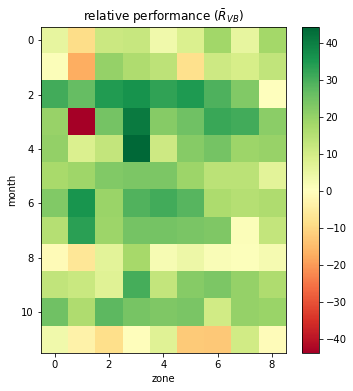

In [689]:
plt.figure(figsize=(6,6))
plt.imshow(relative_perfs.values, cmap="RdYlGn")
plt.ylabel("month")
plt.xlabel("zone")
plt.title("relative performance ($\\bar R_{VB}$)")
plt.colorbar()

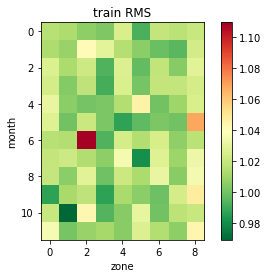

In [691]:
plt.imshow(train_rms.values, cmap="RdYlGn_r")
plt.ylabel("month")
plt.xlabel("zone")
plt.title("train RMS")
plt.colorbar()

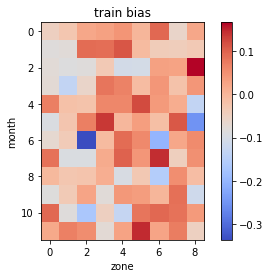

In [684]:
plt.imshow(train_bias.values, cmap="coolwarm")
plt.ylabel("month")
plt.xlabel("zone")
plt.title("train bias")
plt.colorbar()

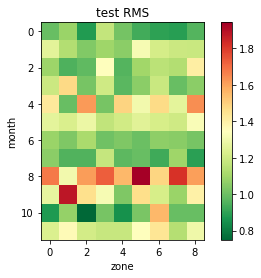

In [690]:
plt.imshow(test_rms.values, cmap="RdYlGn_r")
plt.ylabel("month")
plt.xlabel("zone")
plt.title("test RMS")
plt.colorbar()

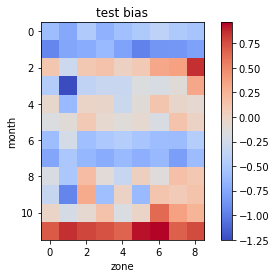

In [685]:
plt.imshow(test_bias.values, cmap="coolwarm")
plt.ylabel("month")
plt.xlabel("zone")
plt.title("test bias")
plt.colorbar()

In [455]:
np.std(z_scores)

1.0196230179721009

In [409]:
relative = relative_perfs[zone_names].values
relative = relative.reshape(relative.size)
relative

array([  5.82228824,  -8.66405786,  11.68861194,  12.48353732,
         3.67115048,   8.40970116,  18.541819  ,   5.70076841,
        18.17776942,   1.26758374, -16.87780895,  20.1656604 ,
        16.59465941,  13.99669211,  -7.90194576,  11.1536861 ,
         9.60197728,  13.23054069,  30.94333193,  26.8691924 ,
        34.63426026,  36.38260084,  32.96448156,  34.99765202,
        29.39038396,  22.89298647,   0.18233853,  20.0664092 ,
       -43.60957071,  24.69059756,  41.06669785,  22.33093143,
        25.33784054,  31.93118703,  31.06309465,  21.68184803,
        20.57913575,   8.6459025 ,  12.87865788,  44.51539057,
        11.22210592,  22.4269531 ,  24.67596736,  19.05292872,
        19.87197434,  17.35857963,  19.0081958 ,  22.83794493,
        23.68135903,  23.66181218,  19.32116003,  14.52088064,
        14.55056886,   6.99051382,  23.03384395,  36.23804493,
        19.61896751,  29.3481198 ,  30.90769188,  28.35799553,
        16.84388954,  15.44002546,  16.61884428,  15.57

In [410]:
np.std(relative)

13.39519604729055

In [411]:
n_samples = 10_000
sample_means = np.zeros((n_samples,))
for i in range(n_samples):
    sample_months = np.random.choice(np.arange(12), size=6, replace=False)
    sample = np.array([relative_perfs.avg.loc[months[j]] for j in sample_months])
    sample_means[i] = sample.mean()

In [412]:
me = sample_means.mean()
er = sample_means.std()
print(me, 2 * er)
me - 2 * er, me + 2 * er

15.462281228052534 5.179562393360934


(10.2827188346916, 20.641843621413468)

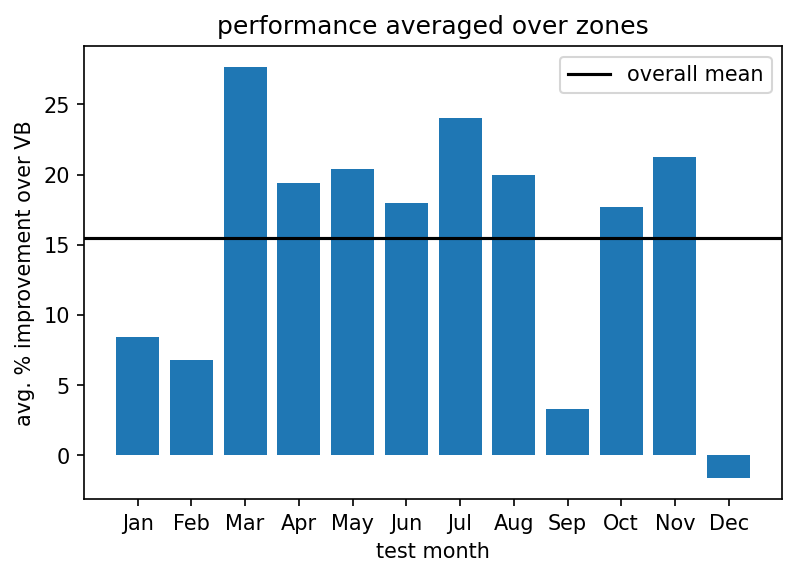

In [245]:
plt.figure(dpi=150)
plt.bar(np.arange(12), relative_perfs.avg, tick_label=relative_perfs.index)
plt.axhline(me, color="k", label="overall mean")
plt.title("performance averaged over zones")
plt.ylabel("avg. % improvement over VB")
plt.xlabel("test month")
plt.legend()

(-0.1841001983984733, 1.2176147822176981)

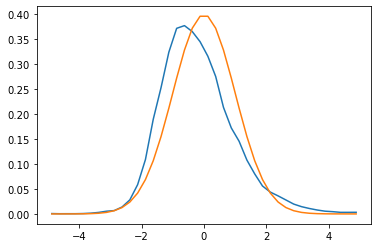

In [477]:
z_hist, bin_edges = np.histogram(test_z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman test z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(test_z_scores), rms(np.array(test_z_scores))

In [249]:
mar_z = np.array(test_z_scores_dict["Mar"])
mar_z.std(axis=1)

array([[1.0848643 ],
       [0.91354227],
       [0.97550009],
       [1.33726253],
       [0.96304868],
       [1.09592319],
       [1.10837243],
       [1.08055566],
       [1.11088114]])

(-0.020943615300314054, 1.0198380919540035)

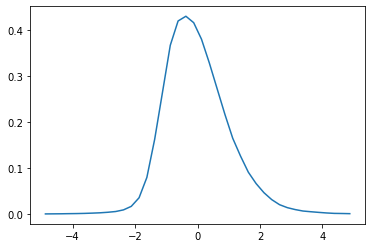

In [252]:
z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman train z-scores")
# plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(z_scores), rms(np.array(z_scores))

In [253]:
list(np.mean(test_z_scores_dict[mo]) for mo in relative_perfs.index)

[-0.5482346399922107,
 -0.8086639521297073,
 0.19317867598754707,
 -0.31055371609322396,
 -0.12223415317870133,
 -0.055647025595199406,
 -0.49467605878606946,
 -0.6628630746730757,
 -0.08662684270371991,
 -0.20224526884700644,
 0.10099044363284551,
 0.7883732315968422]

# periodic trends in uncertainty

In [661]:
import json
month_name = "Dec"
zone_name = "VT"

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print(zones)

month_idx = months.index(month_name)
print("Testing on month", months[month_idx])
test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
test_start = np.argwhere(dates == test_start_date)[0, 0]
test_length = 31 * 24

delay_delta = pd.Timedelta(days=52)
delay = delay_delta.days * 24
train_end_date = test_start_date - delay_delta
train_start_date = train_end_date.replace(year=train_end_date.year - 11)
train_start = np.argwhere(dates == train_start_date)[0, 0]
train_length_delta = train_end_date - train_start_date
train_through = train_length_delta.days * 24
pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
pre_length = pre_length_delta.days * 24

print("MONTH:", month_name)
data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T

# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)
predict_through = train_through + delay + test_length
x = data[train_start:][:predict_through]

['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
Testing on month Dec
MONTH: Dec
data (113952, 1)


In [676]:
train_start_date + delay_delta + pd.Timedelta(days=31)

Timestamp('2007-01-01 00:00:00')

In [663]:
folder = ".\\experiments\\vanilla_comp\\"
for fname in os.listdir(folder):
    if fname.startswith(f"GEFCom_performance_{month_name}{zone_name}"):
        if fname.endswith("mu.npy"):
            print(fname)
            mu_hat = np.load(os.path.join(folder, fname))
        elif fname.endswith("sigma.npy"):
            print(fname)
            sigma_hat = np.load(os.path.join(folder, fname))
        elif fname.endswith("alpha.npy"):
            print(fname)
            alpha_hat = np.load(os.path.join(folder, fname))

GEFCom_performance_DecVT_train_start=15528_2021-05-10_02.28.06.606541trained15528-96432_alpha.npy
GEFCom_performance_DecVT_train_start=15528_2021-05-10_02.28.06.606541trained15528-96432_mu.npy
GEFCom_performance_DecVT_train_start=15528_2021-05-10_02.28.06.606541trained15528-96432_sigma.npy


In [664]:
start = 0
idx = train_through
now = time.time()
quantiles = skewnorm.cdf(x[start:idx], alpha_hat[start:idx], loc=mu_hat[start:idx], scale=sigma_hat[start:idx])
deskewed_z_scores = norm.ppf(quantiles)
print(time.time() - now)

38.717525482177734


In [665]:
z_hist, bin_edges = np.histogram(deskewed_z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
np.mean(deskewed_z_scores), rms(deskewed_z_scores)
np.mean(deskewed_z_scores[np.isfinite(deskewed_z_scores)]), np.std(deskewed_z_scores[np.isfinite(deskewed_z_scores)])

(-0.07424021435739327, 0.9989371439102985)

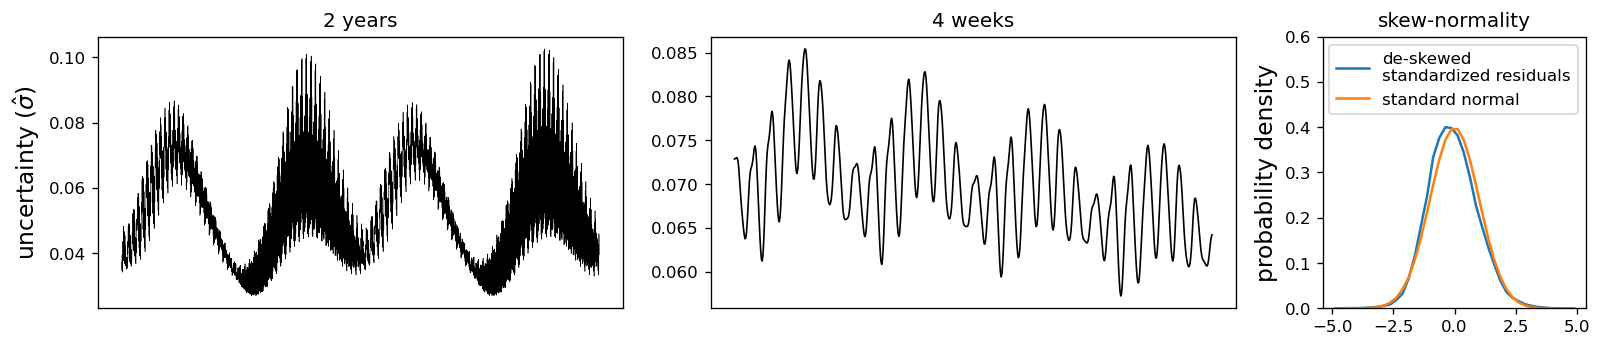

In [677]:
%matplotlib inline
from matplotlib import gridspec
std_hat = skewnorm.std(alpha_hat, loc=mu_hat, scale=sigma_hat)
fig = plt.figure(dpi=120, figsize=(16, 3))
spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[2, 2, 1], height_ratios=[1])
ax0 = fig.add_subplot(spec[0])
plt.title("2 years")
plt.plot(std_hat[:8760 * 2], linewidth=0.35, color="k")
plt.ylabel("uncertainty ($\hat \sigma$)", fontsize=14)
# plt.xlabel("time (hours)")
plt.tick_params(labelbottom=False, bottom=False)
ax0 = fig.add_subplot(spec[1])
plt.title("4 weeks")
st = (52 + 31) * 24
plt.plot(np.arange(st, st + 4 * 168), std_hat[st:st + 4 * 168], linewidth=1, color="k")
plt.tick_params(labelbottom=False, bottom=False)
# plt.xlabel("time (hours)")
ax0 = fig.add_subplot(spec[2])
plt.plot(z_axis, z_hist, label="de-skewed\nstandardized residuals")
plt.plot(z_axis, norm.pdf(z_axis), label="standard normal")
plt.title("skew-normality")
plt.ylabel("probability density", fontsize=14)
plt.ylim([0, 0.6])
plt.legend()

# NASA atmospheric chemistry comparison

In [496]:
import datetime as dt

In [499]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return np.sqrt(np.mean((data - pred)**2)) / (o95 - o05)

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]    

In [509]:
import json
with open(".\\atmo_chem\\NASAcomparison.json") as f:
    NASAcomparison = json.loads(f.read())
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [546]:
xgboost_path = ".\\atmo_chem\\stations\\bias-corrected\\"
station_path = ".\\atmo_chem\\stations\\"
for fname in os.listdir(xgboost_path):
    station_name = fname[len("model_forecast_xgbst_"):-len(".csv")]
    print(station_name)

    obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
    obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
    t_min = obs.t.min()
    obs.t -= t_min

    modfile = os.path.join(xgboost_path, 'model_forecast_xgbst_%s.csv'.replace('%s',station_name))
    mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
    mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
    mod.t -= t_min

    diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
    five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]
    mods = dict()
    for num_ahead in range(1, 6):
        mods[f"ahead{num_ahead}"] = mod[(diff > dt.timedelta(days=num_ahead - 0.5)) & (diff < dt.timedelta(days=num_ahead + 0.5))]

    for i, chemical, chem_name in [(0, "NO2", "NO2"), (1, "O3", "O3"), (2, "PM25", "PM25_RH35_GCC")]:
        obs_chem = obs.loc[obs.obstype==chemical.lower()]
        if len(obs_chem) > 0:
            x = np.expand_dims(obs_chem.conc_obs.values, -1)
            null_idx = np.isnan(x).nonzero()[0]
            if len(null_idx) > 0:
                print("null:", null_idx)
            x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2
            if x.min() <= 0:
                x[x <= 0] = 1e-20
            rnge = np.max(x, axis=0) - np.min(x, axis=0)
            x = x / np.tile(rnge, (x.shape[0], 1))
            t = obs_chem.t.values
            length = min([len(mods[m]) for m in mods])
            mods_chem = [mods[x][chem_name].values[:length] for x in mods.keys()]
            mods_chem = np.array(mods_chem).T

            if chemical == "PM25":
                mod_quant_preds = 1 / rnge * mods_chem
            else:
                mod_quant_preds = 1e9 / rnge * mods_chem
            mod_quant_preds.sort(axis=1)
            modst = mods["ahead1"].t.values[:length]
            set_t = set(t)
            mod_test_idxs = [i for i in range(length) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]
            test_ts_set = set(modst[mod_test_idxs])
            koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
            test_ts = t[koopman_test_idxs]

            quantiles = np.arange(1, 6) / 6
            NASAcomparison[station_name][chemical]["xgbst"] = dict()
            mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
            NASAcomparison[station_name][chemical]["xgbst"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
            NASAcomparison[station_name][chemical]["xgbst"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
            NASAcomparison[station_name][chemical]["xgbst"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
            NASAcomparison[station_name][chemical]["xgbst"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

EEA_DE_DE_DEBY089
EEA_DE_DE_DENW329
EEA_ES_ES1076A
EEA_ES_ES1945A
EEA_FR_FR08017
EEA_FR_FR12021
EEA_FR_FR33101
EEA_PL_PL0317A
EEA_PL_PL0544A
EEA_PL_PL0560A
EEA_SK_SK0407A
JPN_Tokyo_13117520
Station0000036
Station0000468
null: [9662]
null: [9781]
Station0000478
Station0000621
Station0000734
null: [9650]
null: [9765]
Station0000773
null: [9728]
null: [9845]
Station0000805
null: [9736]
null: [9799]
Station0000899
null: [9232]
null: [9360]
Station0001880
null: [9784]
null: [9869]
Station0002146
null: [9666]
null: [9775]
Station0002646
null: [9810]
null: [9896]
Station0002787
null: [9769]
null: [9871]
Station0003102
Station0003167
Station0003253
Station0003746
null: [9683]
null: [9833]
Station0004263
Station0005436
Station0005477
Station0005816
Station0015753
Station0017454


<IPython.core.display.Javascript object>


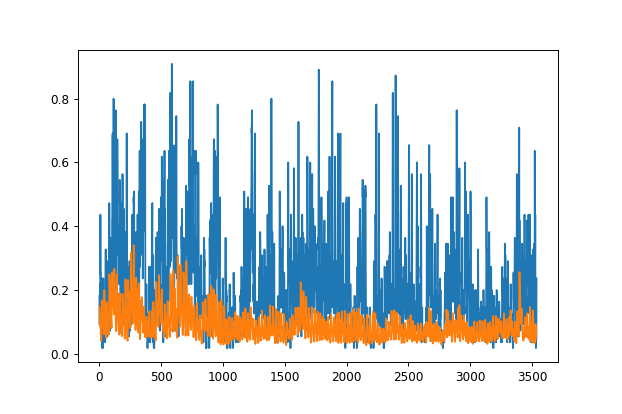

In [570]:
%matplotlib notebook
plt.figure()
plt.plot(x[koopman_test_idxs, 0])
plt.plot(mod_quant_preds[mod_test_idxs, :].mean(axis=1))

### Pinball Loss

In [537]:
NASAcomparison[station_name]

{'NO2': {'koopman': {}, 'NASA': {}},
 'O3': {'koopman': {}, 'NASA': {}},
 'PM25': {'koopman': {'pinball': 0.16552156744937674,
   'nmb': -0.07182858319772142,
   'nrmse': 0.45924206114517324,
   'correlation': 0.5352227819814535},
  'NASA': {'pinball': 0.1906598859197057,
   'nmb': -0.3898620180220592,
   'nrmse': 0.3973987020748972,
   'correlation': 0.3411813919839298},
  'xgbst': {'pinball': 0.004641599628819643,
   'nmb': -0.2884177085397064,
   'nrmse': 0.37069274069695485,
   'correlation': 0.3592337417498471}}}

EEA_DE_DE_DENW329 NO2 was NaN
EEA_ES_ES1076A NO2 was NaN
EEA_ES_ES1076A O3 was NaN
EEA_FR_FR12021 NO2 was NaN
EEA_FR_FR12021 O3 was NaN
EEA_FR_FR33101 NO2 was NaN
EEA_FR_FR33101 O3 was NaN
EEA_IS_IS0053A NO2 was NaN
JPN_Tokyo_13117520 PM25 was NaN
TODO remove

(array([0.000000e+00, 3.600000e+03, 7.200000e+03, ..., 1.009872e+08,
        1.009908e+08, 1.009944e+08]),
 array([31627800., 31631400., 31635000., ..., 46589400., 46593000.,
        46596600.]))

In [518]:
"dfssD".lower()

'dfssd'

In [533]:
set.intersection(set(t), set(modst))

{35020800.0,
 36864000.0,
 42393600.0,
 44236800.0,
 40550400.0,
 46080000.0,
 32374800.0,
 34218000.0,
 37904400.0,
 39747600.0,
 41590800.0,
 43434000.0,
 45277200.0,
 33415200.0,
 35258400.0,
 37101600.0,
 38944800.0,
 40788000.0,
 42631200.0,
 44474400.0,
 46317600.0,
 32612400.0,
 34455600.0,
 38142000.0,
 39985200.0,
 41828400.0,
 43671600.0,
 45514800.0,
 31809600.0,
 33652800.0,
 35496000.0,
 37339200.0,
 39182400.0,
 41025600.0,
 42868800.0,
 44712000.0,
 46555200.0,
 32850000.0,
 34693200.0,
 36536400.0,
 38379600.0,
 40222800.0,
 42066000.0,
 45752400.0,
 32047200.0,
 33890400.0,
 35733600.0,
 37576800.0,
 39420000.0,
 41263200.0,
 43106400.0,
 44949600.0,
 33087600.0,
 34930800.0,
 36774000.0,
 40460400.0,
 42303600.0,
 45990000.0,
 32284800.0,
 35971200.0,
 37814400.0,
 41500800.0,
 43344000.0,
 45187200.0,
 33325200.0,
 35168400.0,
 37011600.0,
 38854800.0,
 40698000.0,
 42541200.0,
 44384400.0,
 32522400.0,
 34365600.0,
 36208800.0,
 39895200.0,
 41738400.0,
 43581600.0,

In [491]:
len(NASAcomparison)

50

In [564]:
pinball = pd.DataFrame({"koopman": {"NO2": [], "O3": [], "PM25": []}, "NASA": {"NO2": [], "O3": [], "PM25": []}, "xgbst": {"NO2": [], "O3": [], "PM25": []}})
nmb = pd.DataFrame({"koopman": {"NO2": [], "O3": [], "PM25": []}, "NASA": {"NO2": [], "O3": [], "PM25": []}, "xgbst": {"NO2": [], "O3": [], "PM25": []}})
nrmse = pd.DataFrame({"koopman": {"NO2": [], "O3": [], "PM25": []}, "NASA": {"NO2": [], "O3": [], "PM25": []}, "xgbst": {"NO2": [], "O3": [], "PM25": []}})
correlation = pd.DataFrame({"koopman": {"NO2": [], "O3": [], "PM25": []}, "NASA": {"NO2": [], "O3": [], "PM25": []}, "xgbst": {"NO2": [], "O3": [], "PM25": []}})
pinball_means = pd.DataFrame({"koopman": {"NO2": [], "O3": [], "PM25": []}, "NASA": {"NO2": [], "O3": [], "PM25": []}, "xgbst": {"NO2": [], "O3": [], "PM25": []}})
chem_names = ["NO$_2$", "O$_3$", "PM$_{2.5}$"]

for station in NASAcomparison:
    """Comparisons on stations 478 and 621 are excluded because there were no observations from the last 9 months of the training year."""
    if station not in ["Station0000478", "Station0000621"]:
        for chemical in ["NO2", "O3", "PM25"]:
            if NASAcomparison[station][chemical]["koopman"] != {} and "xgbst" in NASAcomparison[station][chemical]: # make sure data was there
                if np.isfinite(NASAcomparison[station][chemical]["koopman"]["pinball"]):
                    pinball["koopman"][chemical].append(NASAcomparison[station][chemical]["koopman"]["pinball"])
                    pinball["NASA"][chemical].append(NASAcomparison[station][chemical]["NASA"]["pinball"])
                    nmb["koopman"][chemical].append(NASAcomparison[station][chemical]["koopman"]["nmb"])
                    nmb["NASA"][chemical].append(NASAcomparison[station][chemical]["NASA"]["nmb"])
                    nrmse["koopman"][chemical].append(NASAcomparison[station][chemical]["koopman"]["nrmse"])
                    nrmse["NASA"][chemical].append(NASAcomparison[station][chemical]["NASA"]["nrmse"])
                    correlation["koopman"][chemical].append(NASAcomparison[station][chemical]["koopman"]["correlation"])
                    correlation["NASA"][chemical].append(NASAcomparison[station][chemical]["NASA"]["correlation"])
                    pinball["xgbst"][chemical].append(NASAcomparison[station][chemical]["xgbst"]["pinball"])
                    nmb["xgbst"][chemical].append(NASAcomparison[station][chemical]["xgbst"]["nmb"])
                    nrmse["xgbst"][chemical].append(NASAcomparison[station][chemical]["xgbst"]["nrmse"])
                    correlation["xgbst"][chemical].append(NASAcomparison[station][chemical]["xgbst"]["correlation"])
                else:
                    print(station + " " + chemical + " was NaN")


In [565]:
[len(p) for p in pinball.loc["PM25"]]

[19, 19, 19]

<IPython.core.display.Javascript object>


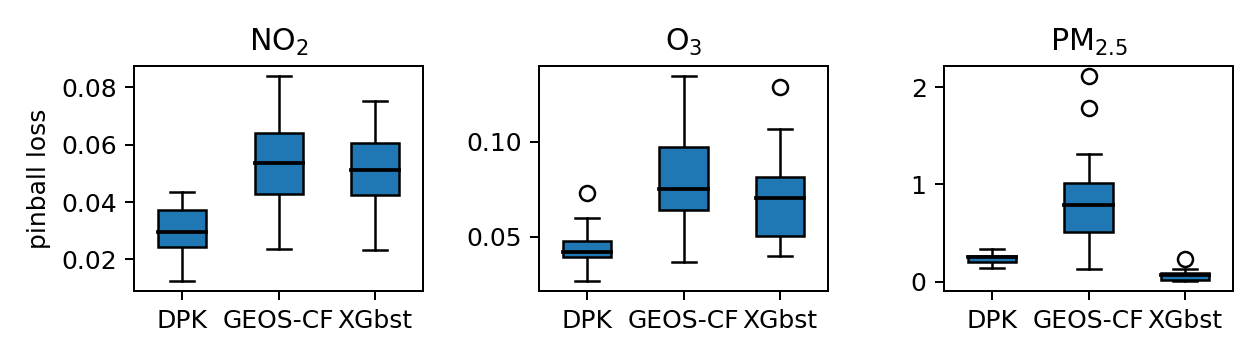

In [567]:
plt.subplots(figsize=(7, 2), dpi=150)
for i, chem in enumerate(pinball.index[::-1]):
    plt.subplot(1, 3, 3 - i)
    for col in pinball.columns:
        p = np.array(pinball[col][chem])
        pinball[col][chem] = p
        pinball_means[col][chem] = p.mean()
    plt.boxplot(pinball.loc[chem], widths=[0.5, 0.5, 0.5], showfliers=True, patch_artist=True, labels=["DPK", "GEOS-CF", "XGbst"], medianprops={"linewidth":1.5, "color":'k'})
    plt.title(chem_names[2 - i])
plt.ylabel("pinball loss")
plt.tight_layout()

In [399]:
pinball_means

,koopman,NASA
NO2,0.028619,0.048171
O3,0.042710,0.074578
PM25,0.235174,0.704829


<IPython.core.display.Javascript object>


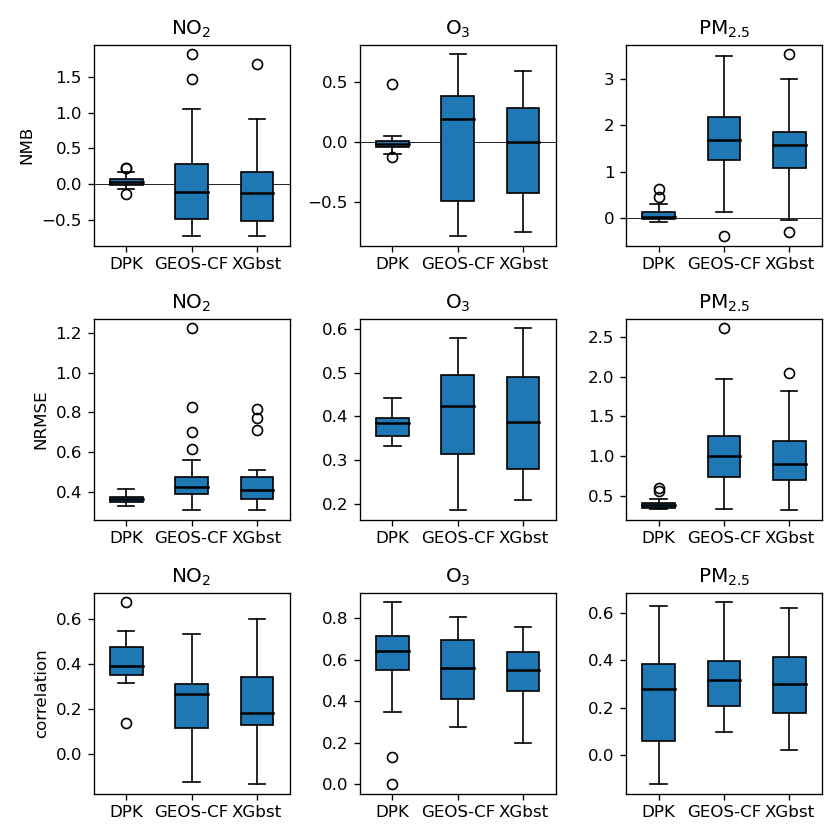

In [569]:
plt.subplots(figsize=(7, 7), dpi=100)
for i, chem in enumerate(nmb.index[::-1]):
    plt.subplot(3, 3, 3 - i)
    for col in nmb.columns:
        p = np.array(nmb[col][chem])
        nmb[col][chem] = p
    plt.boxplot(nmb.loc[chem], widths=[0.5, 0.5, 0.5], showfliers=True, patch_artist=True, labels=["DPK", "GEOS-CF", "XGbst"], medianprops={"linewidth":1.5, "color":'k'})
    plt.title(chem_names[2 - i])
    plt.axhline(0, color="k", linewidth=0.5)
plt.ylabel("NMB")
plt.tight_layout()

for i, chem in enumerate(nrmse.index[::-1]):
    plt.subplot(3, 3, 3 - i + 3)
    for col in nrmse.columns:
        p = np.array(nrmse[col][chem])
        nrmse[col][chem] = p
    plt.boxplot(nrmse.loc[chem], widths=[0.5, 0.5, 0.5], showfliers=True, patch_artist=True, labels=["DPK", "GEOS-CF", "XGbst"], medianprops={"linewidth":1.5, "color":'k'})
    plt.title(chem_names[2 - i])
plt.ylabel("NRMSE")
plt.tight_layout()

for i, chem in enumerate(correlation.index[::-1]):
    plt.subplot(3, 3, 3 - i + 6)
    for col in correlation.columns:
        p = np.array(correlation[col][chem])
        correlation[col][chem] = p
    plt.boxplot(correlation.loc[chem], widths=[0.5, 0.5, 0.5], showfliers=True, patch_artist=True, labels=["DPK", "GEOS-CF", "XGbst"], medianprops={"linewidth":1.5, "color":'k'})
    plt.title(chem_names[2 - i])
plt.ylabel("correlation")
plt.tight_layout()

# GEFCom consistency table

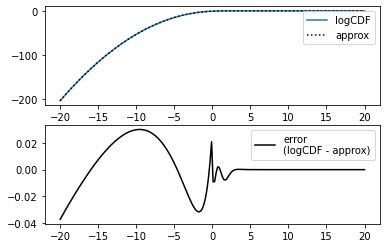

In [707]:
from scipy.stats import norm
import torch
import torch.nn.functional as F

z = torch.linspace(-20, 20, 200)

#  https://stats.stackexchange.com/questions/106003/approximation-of-logarithm-of-standard-normal-cdf-for-x0/107548#107548?newreg=5e5f6365aa7046aba1c447e8ae263fec
# I found this approx to be good: less than 0.04 error for all -20 < x < -5
# approx = lambda x: -0.5 * x ** 2 - 4.8 + 2509 * (x - 13) / ((x - 40) ** 2 * (x - 5))
ans = torch.where(z < -0.1, -0.5 * z ** 2 - 4.8 + 2509 * (z - 13) / ((z - 40) ** 2 * (z - 5)),
                            -torch.exp(-z * 2) / 2 - torch.exp(-(z - 0.2) ** 2) * 0.2)

lp = norm.logcdf(z)
plt.figure()
plt.subplot(211)
plt.plot(z, lp, label="logCDF")
plt.plot(z, ans, ":k", label="approx")
plt.legend()
plt.subplot(212)
plt.plot(z, lp-ans.numpy(), "k", label="error\n(logCDF - approx)")
plt.legend()